<a href="https://colab.research.google.com/github/malinowakrew/text_classifier_sentiment/blob/master/text_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment analysis

In [ ]:
import tensorflow as tf
import string
import numpy as np

import pandas as pd
import random 

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

This library is not nessesary in this notebook but I leave this here.

In [ ]:
import tensorflow_datasets as tfds 
import os

## Alternative version for data load to kernel

In [ ]:
! git clone https://github.com/malinowakrew/text_classifier_sentiment.git # nie powinno być potrzeby naciskania bo już klonowałam

Cloning into 'text_classifier_sentiment'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.


## Data preparation

We will be using twitts about COVID19, labeled manually. We choose to use encoder latina-1 because defoult utf-8 didin't match every data. 

In [ ]:
data = pd.read_csv("text_classifier_sentiment/Corona_NLP_train.csv", encoding='latin-1')

Let's check how our data looks like.

In [ ]:
data.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toile...,Neutral
8,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,Positive
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...",Negative


We need only the last two columns.

In [ ]:
dataset = data[["OriginalTweet", "Sentiment"]]

In [ ]:
dataset["Sentiment"].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

We shuffle data in case there have some specific order.

In [ ]:
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.head(10)

,OriginalTweet,Sentiment
0,? HAPPY M O N D A Y Friends ?\r\r\n-\r\r\nI kn...,Extremely Positive
1,All about positive thinking.\r\r\nHereÂs some...,Extremely Negative
2,Washing hands with SOAP fights Here s why it...,Neutral
3,#coronavirus : les #masques arrivent\r\r\n#des...,Neutral
4,"@McDonaldsUK in Dagenham, east London has shut...",Extremely Negative
5,Covid 19 at Shopping mall or supermarket meanw...,Positive
6,Syrian Trading shopping centers continue offer...,Neutral
7,The #Coronavirus Outbreak is Making Dairy Farm...,Negative
8,There are elderly people amp families not able...,Extremely Negative
9,we cannot simply rely on government to get us...,Neutral


We also need to change written labels to numerical ones. Replacing some text like "\r" will be helpfull, too.

In [ ]:
#To_numerical
cleanup_nums = [i for i in range(len(list(dataset.iloc[:, -1].unique())))]
cleanup = {(list(dataset.iloc[:, -1].unique())[i]): i for i in cleanup_nums}
cleanup2 = {'Extremely Negative': 0, 'Extremely Positive': 1, 'Positive': 1, 'Negative': 0, 'Neutral': 2}
print(f"Groups: {cleanup2}")
dataset = dataset.replace(cleanup2)

#replacing patterns - we can find more unsueful patterns
dataset.replace('\r{1,}','',regex=True, inplace = True)

#show data
dataset.head(10)

Groups: {'Extremely Negative': 0, 'Extremely Positive': 1, 'Positive': 1, 'Negative': 0, 'Neutral': 2}


,OriginalTweet,Sentiment
0,HAPPY Friends know everyone uneasy thats go #c...,1
1,positive thinking. HereÂs example negative th...,0
2,Washing hand SOAP fight Here work well,2
3,#coronavirus #masques arrivent #dessindepresse...,2
4,"@McDonaldsUK Dagenham, east London shut shop e...",0
5,Covid Shopping mall supermarket meanwhile prep...,1
6,Syrian Trading shopping center continue offeri...,2
7,#Coronavirus Outbreak Making Dairy Farmers Dum...,0
8,There elderly people family able grocery peopl...,0
9,cannot simply rely government business employe...,2


In [ ]:
dataset.Sentiment.value_counts()

1    18046
0    15398
2     7713
Name: Sentiment, dtype: int64

In [ ]:
print(STOPWORDS)

{'in', 'was', 'doesn', 'if', 'ourselves', 'is', 'o', 'other', "you'll", 'only', 'out', "isn't", 'then', 'into', 'below', 'do', 'am', 'haven', 'to', "don't", 'ma', 'your', 'needn', 'nor', 'too', 'isn', 'from', "didn't", 'were', 'as', 'on', 're', 'off', 'such', "wasn't", 'own', 'i', 'whom', 'more', 'through', 'the', 'have', "it's", 'yourself', 'doing', 'them', 'until', 'during', 'itself', 't', 'those', "hadn't", 'can', 'didn', "you're", "hasn't", 'why', 'does', 'shan', 'all', 'yourselves', 'he', "you've", 'been', 'at', 'my', 'covid19', 'its', 'this', 'had', 'down', 'that', 'will', 'these', 'against', 'about', 'aren', 'after', 'yours', 'with', "you'd", 'when', "doesn't", "mustn't", 'who', "haven't", 'being', 'won', 'above', 'y', 's', 'under', 'just', 'so', 'did', 'by', 'weren', 'him', "should've", 've', 'll', 'no', 'before', 'while', "that'll", 'our', "won't", 'hadn', 'between', 'than', 'are', 'but', "aren't", "couldn't", 'we', "shouldn't", 'm', 'for', 'or', 'couldn', 'has', 'further', 'b

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
STOPWORDS = STOPWORDS | {'coronavirus', 'covid19'}

from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()


from nltk import pos_tag


nltk.download('averaged_perceptron_tagger')
def get_pos_tag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        # As default pos in lemmatization is Noun
        return wordnet.NOUN


for nr, i in enumerate(dataset["OriginalTweet"]):
  text = " ".join(lemmatizer.lemmatize(word.strip(), get_pos_tag(pos_tag([word.strip()])[0][1])) for word in i.split() if word not in STOPWORDS and len(word)>3)
  dataset.iloc[nr, 0] = text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Splitting data into two groups. One is for training and one for validation model. 

In [ ]:
num = int(dataset.shape[0]*0.7)
dataset_train = dataset.iloc[num:, :]
dataset_test = dataset.iloc[:num, :]

print(f"{dataset_test.shape}, {dataset.shape}")

(28809, 2), (41157, 2)


Numerical labels still are not what we really want. We will change them to one-hots.

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
dataset_labels = to_categorical(dataset_train["Sentiment"].astype('category'))
dataset_tf = tf.data.Dataset.from_tensor_slices((dataset_train["OriginalTweet"], dataset_labels))


dataset_tf_test_labels = to_categorical(dataset_test["Sentiment"].astype('category'))
dataset_tf_test = tf.data.Dataset.from_tensor_slices((dataset_test["OriginalTweet"], dataset_tf_test_labels))


Let's see our work. Now we have text and one-hot labels.

In [ ]:
for feat, sec in dataset_tf.take(5):
    print('Features: {}, Target: {}'.format(feat, sec))

Features: b'#jacobreesmogg Buying business slash prices, Profiteering Covid people misery, sell abortion pill 2017 spout anti abortion religious stance national television "HYPOCRISY" high level #BorisJohnson sack now. https://t.co/xvBglJW69R', Target: [1. 0. 0.]
Features: b'successfully #FlattenTheCurve #CoronavirusPandemic, need part perform duty &amp; think collective good. This include serious #StayHomeSaveLives &amp; yes, follow rule local grocery store', Target: [0. 1. 0.]
Features: b'Northland supermarket staff member test positive COVID', Target: [0. 1. 0.]
Features: b'Following sharp drop price impact declare support review 2020 budget know best cope crisis', Target: [0. 1. 0.]
Features: b'base startup develops sanitisation unit sanitizer ward challenge center', Target: [0. 1. 0.]


## Model building

It is big time. Now we are going to define encoder layer. This layer will take out text and return us vectors which describe it. We also adapt this encoder to our data.

In [ ]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(dataset_tf.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'covid19', 'coronavirus', 'price', 'store',
       'consumer', 'grocery', 'supermarket', 'food', 'covid', 'people',
       'pandemic', 'sanitizer', 'amp', 'hand', 'shopping', 'online',
       'demand', 'need'], dtype='<U19')

Becaouse we use vocab size, ot every dingle word will be important to us. Let's see how text looks like after use encoder. This is only prezentation. This step is not important in our model.

In [ ]:
example = dataset["OriginalTweet"]
encoded = encoder(example).numpy()

vocab = np.array(encoder.get_vocabulary())
print(vocab[:20])

for n in range(3):
    print("Original: ", example[n])
    print("Round-trip: ", " ".join(vocab[encoded[n]]))

['' '[UNK]' 'coronavirus' 'covid19' 'store' 'supermarket' 'food' 'price'
 'grocery' 'people' 'consumer' 'amp' 'shopping' 'need' 'online' 'covid'
 'work' 'pandemic' 'time' 'go']
Original:  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
Round-trip:  [UNK] [UNK] [UNK] [UNK] and [UNK] and [UNK]                                                        
Original:  advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order
Round-trip:  advice talk [UNK] your [UNK] family [UNK] [UNK] phone [UNK] create contact list with phone [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] online shopping [UNK] [UNK] [UNK] [UNK] supplies [UNK] [UNK] [UNK] [UNK] not over order                          
Original:  Coronavirus Australia: Woolworths to give elderly, disa

In this step we define every layer in our model and describe it. 

In [ ]:
model = tf.keras.Sequential([
    encoder, #vectorizing text
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True), #changing the shape of data: integers to dense vectors
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), #hidden layers - this is a wrapper. We will describe this below.
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3)

    # tf.keras.layers.Dense(64, activation='relu'), #normal layer with typical activation function
    # tf.keras.layers.Dropout(0.5), #to avoid overfitting
    # tf.keras.layers.Dense(64, activation='relu'), #normal layer with typical activation function
    # tf.keras.layers.Dropout(0.5), #to avoid overfitting
    # tf.keras.layers.Dense(5) #normal last layer which give us logits
])

In [ ]:
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, embedding_dim, input_length=len(encoder.get_vocabulary())),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(VOCAB_SIZE,return_sequences=True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3)
])

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(3)
])

# PLACE TO DESCRIBE RNN MODELS

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.00352697  0.00587284 -0.00418681]


Our model is not done yet. We need to write how to compile him. 

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), #!binary
              optimizer=tf.keras.optimizers.Adam(), #tf.keras.optimizers.SGD() #1e-4
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

In [ ]:
dataset_tf_test

<TensorSliceDataset shapes: ((), (3,)), types: (tf.string, tf.float32)>

We split data to portions.

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset_tf_batch = dataset_tf.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_tf_test_batch = dataset_tf_test.batch(BATCH_SIZE)

Activate progress bar.

In [ ]:
tfds.disable_progress_bar()
dataset_tf_test = dataset

Activate training our model

In [ ]:
history = model.fit(dataset_tf_batch, epochs=5,
                    validation_data=dataset_tf_test_batch)
                    #validation_steps=15)

Epoch 1/3
193/193 [==============================] - 22s 71ms/step - loss: 1.0158 - accuracy: 0.4655 - val_loss: 0.7914 - val_accuracy: 0.6510
Epoch 2/3
193/193 [==============================] - 11s 59ms/step - loss: 0.7131 - accuracy: 0.7153 - val_loss: 0.7183 - val_accuracy: 0.6927
Epoch 3/3
193/193 [==============================] - 12s 60ms/step - loss: 0.6423 - accuracy: 0.7478 - val_loss: 0.7115 - val_accuracy: 0.6979


Use other data to evaluate our model.

In [ ]:
data= pd.read_csv("text_classifier_sentiment/Corona_NLP_test.csv", encoding='latin-1')

dataset_train = data[["OriginalTweet", "Sentiment"]]

#cleanup_nums = [i for i in range(len(list(dataset.iloc[:, -1].unique())))]
#cleanup = {(list(dataset.iloc[:, -1].unique())[i]): i for i in cleanup_nums}
cleanup = {'Extremely Negative': 0, 'Extremely Positive': 1, 'Positive': 1, 'Negative': 0, 'Neutral': 2}
dataset_train = dataset_train.replace(cleanup)

print(dataset_train["Sentiment"].value_counts())

dataset_train.replace('\r{1,}','',regex=True, inplace = True)


dataset_labels = to_categorical(dataset_train["Sentiment"].astype('category'))
dataset_tf = tf.data.Dataset.from_tensor_slices((dataset_train["OriginalTweet"], dataset_labels))
dataset_tf = dataset_tf.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_loss, test_acc = model.evaluate(dataset_tf)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

0    1633
1    1546
2     619
Name: Sentiment, dtype: int64
60/60 [==============================] - 2s 27ms/step - loss: 0.8039 - accuracy: 0.6382
Test Loss: 0.8039377331733704
Test Accuracy: 0.6382306218147278


In [ ]:
dataset["Sentiment"].value_counts()

1    11422
3     9917
0     7713
4     6624
2     5481
Name: Sentiment, dtype: int64

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

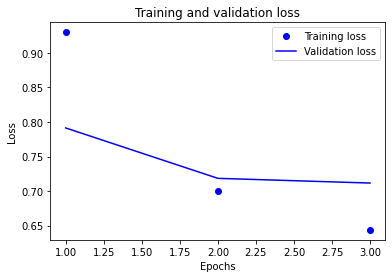

In [ ]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

import matplotlib.pyplot as plt

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

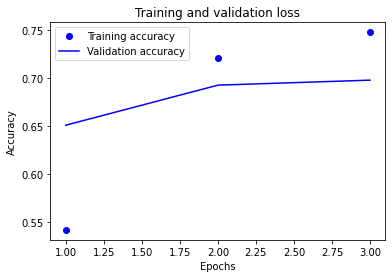

In [ ]:
# "bo" is for "blue dot"
plt.plot(epochs, acc, 'bo', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# SPACE TO PCA OR T-SNE